In [1]:
from processed_data import UTKFace
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

torch.Size([1, 200, 200])


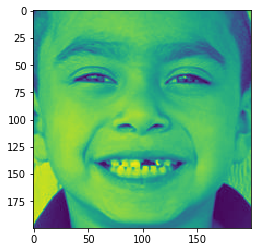

In [2]:
foo = UTKFace.Dataset(train=True, transform=transforms.ToTensor())
print(foo[0][0].shape)
plt.imshow(foo[0][0].reshape(200, 200))

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import copy
import numpy as np
from models.UTKFace.vae import VAE


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=5, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--load', action='store_true', default=False, help='Skip Training')
args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    foo,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    foo,
    batch_size=args.batch_size, shuffle=True, **kwargs)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1, 200, 200), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def build_mnist_dataset_with_only_label_from_dataset(d, label, test=False):
    nd = copy.deepcopy(d)
    idxs_with_label = []

    for i in range(0, len(d)):
        if d[i][1] == label:
            idxs_with_label.append(i)

    if test:
        nd.test_data = nd.test_data[idxs_with_label]
        nd.test_labels = nd.test_labels[idxs_with_label]
    else:
        nd.data = nd.data[idxs_with_label]
        nd.targets = nd.targets[idxs_with_label]

    return nd

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 200, 200)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

def main():
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 200, 200) * 255,
                       'results/sample_' + str(epoch) + '.png')

    torch.save(model.state_dict(), 'model.pt')


In [ ]:
import matplotlib.pyplot as plt
main()

Train Epoch: 1 [0/23708 (0%)]	Loss: 28563.240234
Train Epoch: 1 [1280/23708 (5%)]	Loss: 4968.975586
Train Epoch: 1 [2560/23708 (11%)]	Loss: 2923.051514
Train Epoch: 1 [3840/23708 (16%)]	Loss: 3814.914551
Train Epoch: 1 [5120/23708 (22%)]	Loss: 3117.701416
Train Epoch: 1 [6400/23708 (27%)]	Loss: 3926.697021
Train Epoch: 1 [7680/23708 (32%)]	Loss: 4281.447266
Train Epoch: 1 [8960/23708 (38%)]	Loss: 4076.501953
Train Epoch: 1 [10240/23708 (43%)]	Loss: 4031.467041
Train Epoch: 1 [11520/23708 (48%)]	Loss: 3763.886475
Train Epoch: 1 [12800/23708 (54%)]	Loss: 3392.362549
Train Epoch: 1 [14080/23708 (59%)]	Loss: 3067.972900
Train Epoch: 1 [15360/23708 (65%)]	Loss: 2690.581543
Train Epoch: 1 [16640/23708 (70%)]	Loss: 1838.785889
Train Epoch: 1 [17920/23708 (75%)]	Loss: 1437.952881
Train Epoch: 1 [19200/23708 (81%)]	Loss: 940.657104
Train Epoch: 1 [20480/23708 (86%)]	Loss: 818.270081
Train Epoch: 1 [21760/23708 (91%)]	Loss: 756.653931
Train Epoch: 1 [23040/23708 (97%)]	Loss: 730.330933
====> Epo